Train cyclegan to translate synthethic images to easy images


In [1]:
# add parent dir to syspath
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

# Imports 

In [2]:
# own imports
from models.cyclegan_modified.cyclegan import cyclegan
#from models.cyclewgan.cyclegan import cyclegan
from imageGenerators import load_digits, load_realdata
from imageGenerators.imgGen_simple import synth_generator
from imageGenerators.imgGen_augmented import synth_generator as synth_generator_new

import models.common_functions 
# librarys
import tensorflow as tf
import cv2
from pathlib import Path
from matplotlib import pyplot as plt
from os import listdir, mkdir
import os
import numpy as np
import time
import pickle
import random

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
# assert model is running on gpu
from tensorflow.python.client import device_lib
devlist = str(device_lib.list_local_devices())
assert "GPU:0" in devlist

# Parameters 

In [4]:
useNewGenerator = True



#N_TEST = 5
N_DIGITS = 5
BATCH_SIZE = 1
BUFFER_SIZE = 1000




lr=0.0002

N_IMAGES = 512
poolsize = 0
adversial_lossfunction = "bce" # either mse or bce
_lambda = 10 # weight of cycleloss
EPOCHS = 3

# all images will be resized to these dimensions
#                  width, height
IMAGE_DIMENSIONS = (512, 128)
# whether to train on images with channel==1, or 3
GRAYSCALE = True
N_CHANNELS = 1 if GRAYSCALE else 3

#              height,              width,               channels
IMAGE_SHAPE = (IMAGE_DIMENSIONS[1], IMAGE_DIMENSIONS[0], N_CHANNELS)

CHECKPOINTPATH = Path("D:/m2/savedmodels/goals/q5_lambda/n%d_lambda%d_2" % (N_IMAGES, _lambda) )
CHECKPOINTPATH.mkdir()






# generate synthetic images (Domain A)

In [5]:
digitsTest = [
        [digit for _ in range(N_DIGITS)]
        for digit in range(20)
    ]
digitsTrain = np.random.randint(0,20,size=(N_IMAGES, N_DIGITS))
def generate_synthetic(show_generated=0):
    # init imagegenerator
    synthGenerator = synth_generator(vertical_margin=20)
    
    # how far can a digit be scrolled down for it to be considered midstate/normalstate
    midstate_range=(0.3,0.7) # scrolling down so much that two digits are on screen
    normalstate_range=(-0.2,0.2) # scrolling up or down a little keeps normalstate

    # prepare inputdigits 
    digitsTrain = np.random.randint(0,20,size=(N_IMAGES, N_DIGITS))
    #digitsTest = np.random.randint(0,20,size=(N_TEST, N_DIGITS))
    
    
    # params to imagegenerator
    margins = 20 # distances between digits
    border = (2, 2, 2, 2) # padding of resultimage
    height = IMAGE_DIMENSIONS[1]; width= IMAGE_DIMENSIONS[0] # dimensions to resize result to
    # generate images
    synthTrain = synthGenerator.generate_images(digitsTrain, margins, border, width, height, range_normal=normalstate_range,range_midstate=midstate_range)
    synthTest = synthGenerator.generate_images(digitsTest, margins, border, width, height, range_normal=normalstate_range,range_midstate=midstate_range)
    
    print("Generated synthetic images: %s" % (str(synthTrain.shape)) )
    show_generated = min(show_generated, N_IMAGES)
    if show_generated > 0:
        for i in range(show_generated):    
            print(digitsTrain[i])
            plt.imshow(synthTrain[i], cmap='gray')
            plt.show()
    return synthTrain, synthTest, digitsTest

def generate_synthetic_newGenerator(show_generated=0):
    synthGenerator = synth_generator_new()
    #digitsTrain = np.random.randint(0,20,size=(N_IMAGES, N_DIGITS))
    #digitsTest = np.random.randint(0,20,size=(N_TEST, N_DIGITS))
    synthTrain = synthGenerator.makeImages(digitsTrain, resizeTo=IMAGE_DIMENSIONS, color=True, rotate=True)
    synthTest = synthGenerator.makeImages(digitsTest, resizeTo=IMAGE_DIMENSIONS, color=True, rotate=True)
    
    print("Generated synthetic images: %s" % (str(synthTrain.shape)) )
    if show_generated > 0:
        for i in range(show_generated):    
            print(digitsTrain[i])
            plt.imshow(synthTrain[i,:,:,0], cmap='gray')
            plt.show()
    return synthTrain, synthTest, digitsTest

making new generated images
Generated synthetic images: (512, 128, 512, 1)
[11  6 16 11 14]


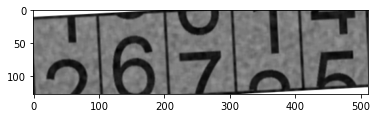

[ 1 13 19 16  0]


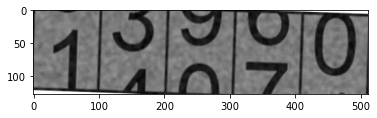

[10 13 12 19  8]


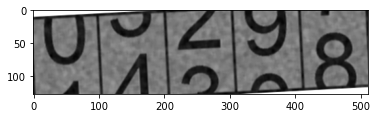

[19 14  5 13 10]


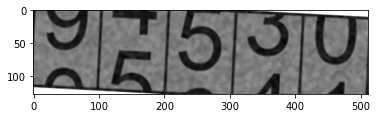

[ 5  2  6 16 10]


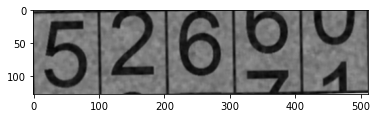

[14  1  6 18 10]


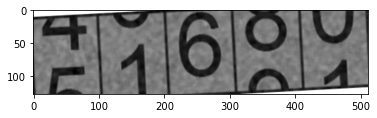

[10 15  4 10  1]


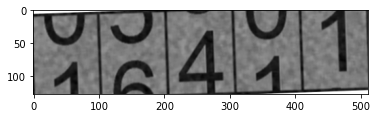

[12 14 15  3  6]


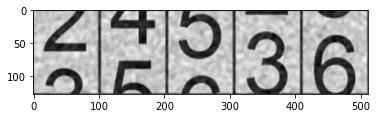

[ 2 15 19 16 16]


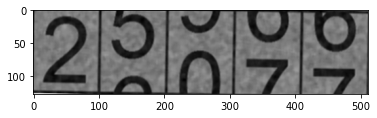

[ 3 10  1 12  2]


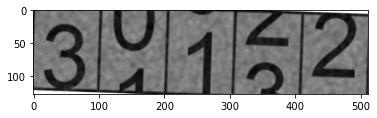

In [6]:
# generate and save, or load synthetic images if file exists
traindatapath = CHECKPOINTPATH / "traindata.pickle"
if traindatapath.exists():
    # reload old dataset to resume training
    print("reloading generated images")
    with open(traindatapath, "rb") as picklefile:
        synthTrain, synthTest, digitsTest = pickle.load(picklefile)
    print("loaded synthetic images: %s" % (str(synthTrain.shape)) )
else:
    # save dataset
    print("making new generated images")
    if useNewGenerator:
        synthTrain, synthTest, digitsTest = generate_synthetic_newGenerator(10)
    else:
        synthTrain, synthTest, digitsTest = generate_synthetic(10)    
    dataset = (synthTrain, synthTest, digitsTest)
    with open(traindatapath, "wb") as picklefile:
        pickle.dump(dataset, picklefile, pickle.HIGHEST_PROTOCOL)
     

# load real images (Domain B)

C:\Users\andre\jupyter_ws\imageGenerators\load_realdata.py:57: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(txt_path, sep=seperators ,header=None)


loaded trainimages (easy): (1000, 128, 512)
[2 0 0 1 2]


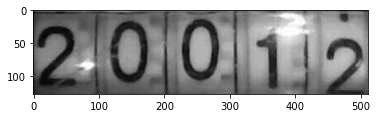

[ 6  0  5  6 16]


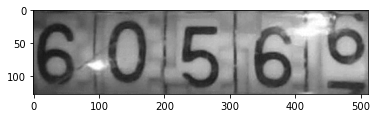

[ 2  6  5  7 17]


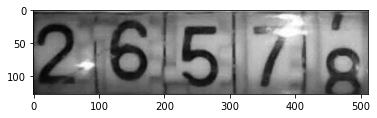

[ 3  4  0  0 18]


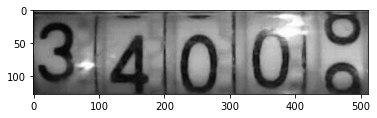

[ 4  6  7  5 13]


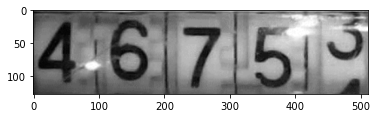

[2 1 6 8 8]


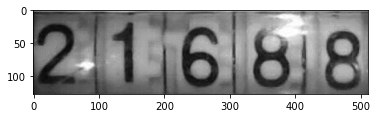

[ 2  7  9  6 17]


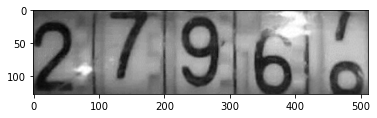

[4 0 8 0 9]


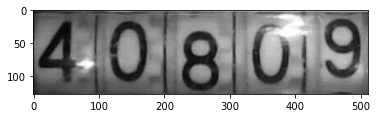

[ 2  8  9  2 10]


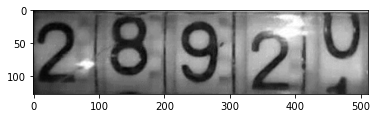

[ 2  0  4  7 13]


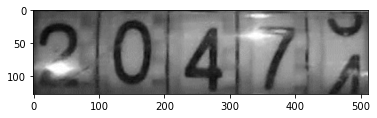

In [7]:
# load easy images and split to train and test
images_easy, labels_easy = load_realdata.load_wmr_easy(resizeTo=IMAGE_DIMENSIONS)
images_easy_train = images_easy[0:N_IMAGES]; labels_easy_train = labels_easy[0:N_IMAGES]
images_easy_test = images_easy[0:N_IMAGES]; labels_easy_test = labels_easy[0:N_IMAGES]



# save labels used for training
labelPath = CHECKPOINTPATH / "training_labels.pickle"
with open(labelPath, "wb") as picklefile:
    pickle.dump( (digitsTrain, labels_easy_train), picklefile, pickle.HIGHEST_PROTOCOL)

print("loaded trainimages (easy): %s" % (str(images_easy.shape)) )
for i in range(10):
    image = images_easy_train[i]
    print(labels_easy_train[i])
    plt.imshow(image, cmap="gray")
    plt.show()

# load model and prepare inputs

In [8]:
#cgModel = cyclegan(IMAGE_SHAPE, adversial_lossfunction, lr=lr, _lambda=_lambda, checkpoint_path=CHECKPOINTPATH)
cgModel = cyclegan(image_shape=IMAGE_SHAPE,
                   n_images=N_IMAGES,
                   batchsize=BATCH_SIZE,
                   adversial_loss=adversial_lossfunction,
                   lr=lr,
                   _lambda=_lambda,
                   poolsize=poolsize,
                   checkpoint_path=CHECKPOINTPATH
                  )

# make tf-Datasets
train_A = tf.data.Dataset.from_tensor_slices(synthTrain) \
        .map(cgModel.preprocess_input, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(BATCH_SIZE)

train_B = tf.data.Dataset.from_tensor_slices(images_easy_train) \
        .map(cgModel.preprocess_input, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(BATCH_SIZE)

test_A = tf.data.Dataset.from_tensor_slices(synthTest)\
        .map(cgModel.preprocess_input, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(BATCH_SIZE)

#test_B = tf.data.Dataset.from_tensor_slices(realTest)

created new Model


# train

epoch 1:
512/512 [==============================] - 794s 2s/step

epoch 1 took: 797.133607 seconds
saved to: D:\m2\savedmodels\goals\q5_lambda\n512_lambda10_2\epoch-1
epoch 2:
512/512 [==============================] - 763s 1s/step

epoch 2 took: 764.026462 seconds
saved to: D:\m2\savedmodels\goals\q5_lambda\n512_lambda10_2\epoch-2
epoch 3:
512/512 [==============================] - 764s 1s/step

epoch 3 took: 767.346075 seconds
saved to: D:\m2\savedmodels\goals\q5_lambda\n512_lambda10_2\epoch-3
Training finished: 2722.341500 seconds


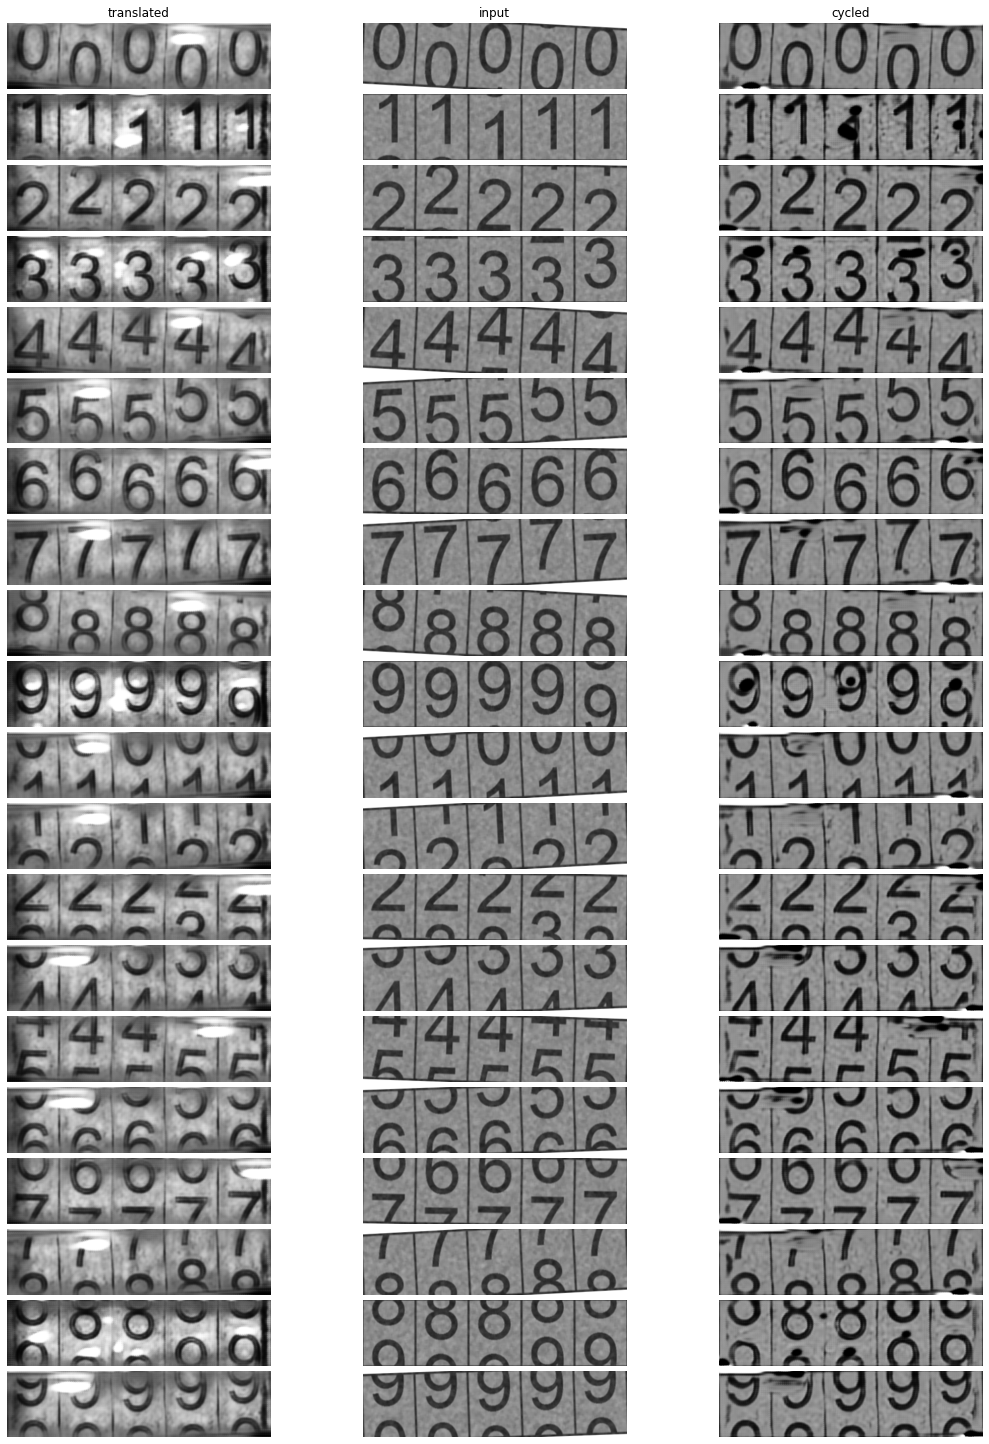

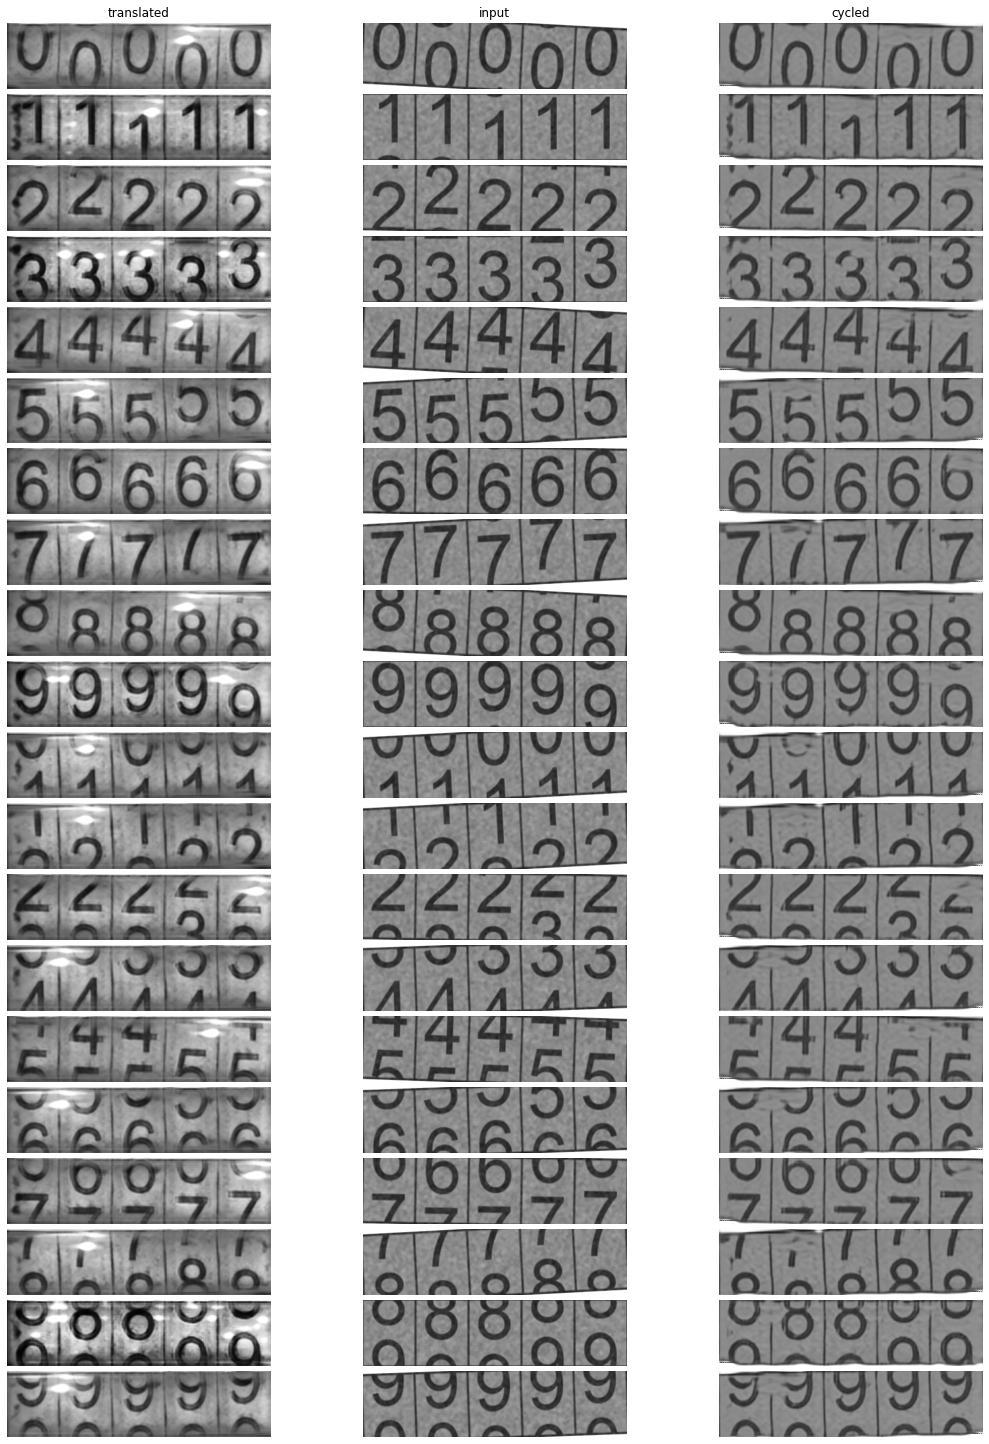

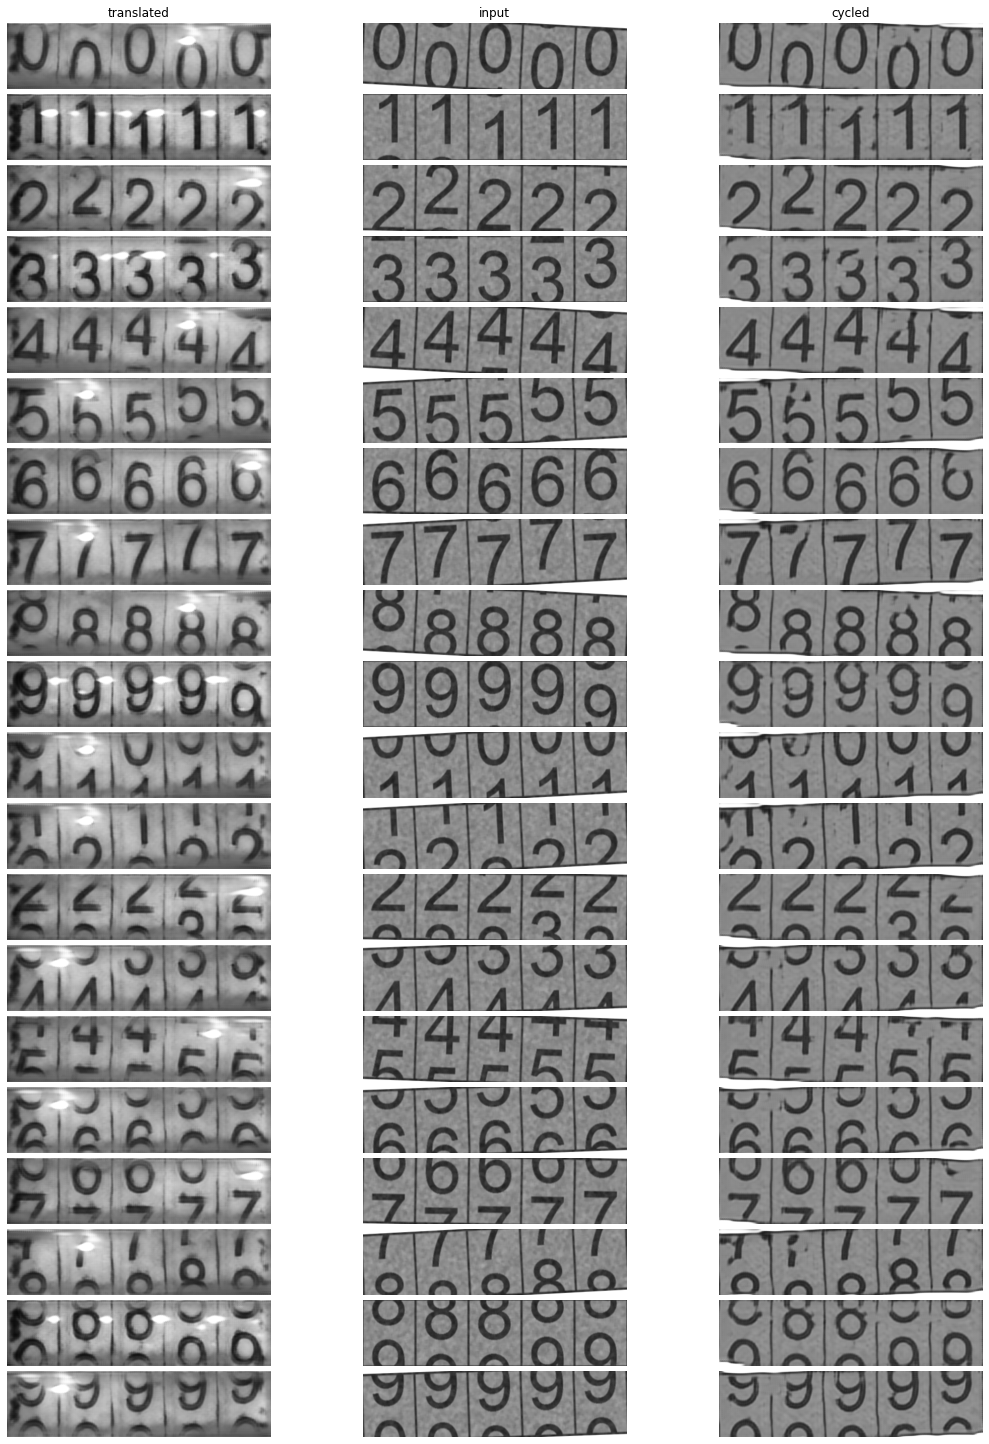

In [9]:
#device_name = "/device:CPU:0"
#with tf.device(device_name):
#    cgModel.train(train_A, train_B, test_A, n_testimages=N_TEST, epochs=EPOCHS, epochs_before_save=2)
cgModel.train(train_A, train_B, test_A, epochs=EPOCHS, epochs_before_save=1)
d_iter = 5
#cgModel.train(train_A, train_B, d_iter, test_A, n_testimages=N_TEST, epochs=EPOCHS, epochs_before_save=2)